In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'test_images', 'train.csv', 'sample_submission.csv', 'train_images']


In [58]:
import pandas as pd
import json
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D,Dropout
from keras.applications import DenseNet169
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.metrics import cohen_kappa_score

In [71]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import VGG19
import numpy as np

base_model = VGG19(weights='imagenet', include_top=False)

In [72]:
from keras import regularizers
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.5)(x)
preds=Dense(5, activation='softmax',kernel_regularizer=regularizers.l2(0.0001))(x)

In [73]:
model = Model(inputs=base_model.input,outputs=preds)

In [74]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.00001),
    metrics=['accuracy']
)


In [75]:
train_df = pd.read_csv('../input/train.csv')
train_df["id_code"]=train_df["id_code"].apply(lambda x:x+".png")
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
train_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [76]:
train_df.count()

id_code      3662
diagnosis    3662
dtype: int64

In [77]:
nb_classes = 5
lbls = list(map(str, range(nb_classes)))
batch_size = 32
img_size = 224
nb_epochs = 15

In [78]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True,
    rotation_range=45,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,   
    zoom_range = 0.3,
    )

In [79]:
train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    classes=lbls,
    target_size=(img_size,img_size),
    subset='training')

print('break')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical", 
    classes=lbls,
    target_size=(img_size,img_size),
    subset='validation')

Found 2930 validated image filenames belonging to 5 classes.
break
Found 732 validated image filenames belonging to 5 classes.


In [80]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 10)
mc = ModelCheckpoint('modeldense.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=30,
    epochs=nb_epochs,
    validation_data=valid_generator,
    validation_steps = 30,
    callbacks=[es,mc]
)

Epoch 1/15
30/30 [==============================] - 247s 8s/step - loss: 1.4051 - acc: 0.4583 - val_loss: 1.2065 - val_acc: 0.4749

Epoch 00001: val_loss improved from inf to 1.20652, saving model to modeldense.h5
Epoch 2/15
30/30 [==============================] - 184s 6s/step - loss: 1.1893 - acc: 0.5417 - val_loss: 1.0206 - val_acc: 0.6423

Epoch 00002: val_loss improved from 1.20652 to 1.02061, saving model to modeldense.h5
Epoch 3/15
30/30 [==============================] - 197s 7s/step - loss: 1.1214 - acc: 0.6104 - val_loss: 1.0305 - val_acc: 0.6360

Epoch 00003: val_loss did not improve from 1.02061
Epoch 4/15
30/30 [==============================] - 190s 6s/step - loss: 1.0169 - acc: 0.6266 - val_loss: 0.9861 - val_acc: 0.6408

Epoch 00004: val_loss improved from 1.02061 to 0.98614, saving model to modeldense.h5
Epoch 5/15
30/30 [==============================] - 190s 6s/step - loss: 0.9959 - acc: 0.6562 - val_loss: 0.9188 - val_acc: 0.6831

Epoch 00005: val_loss improved from

In [81]:
history_df

,val_loss,val_acc,loss,acc
0,1.277843,0.551255,1.601087,0.310417
1,1.102833,0.628661,1.364786,0.430208
2,1.004228,0.655858,1.155709,0.561458
3,0.972241,0.653361,1.058576,0.624736
4,0.852901,0.717573,0.971616,0.679167
5,0.897675,0.677824,0.930107,0.659375
6,0.847162,0.697479,0.892459,0.686047
7,0.836501,0.694561,0.809917,0.716667
8,0.771180,0.732218,0.839801,0.697917
9,0.811206,0.705882,0.818899,0.707188


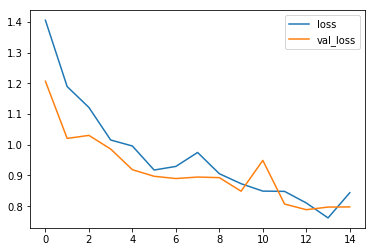

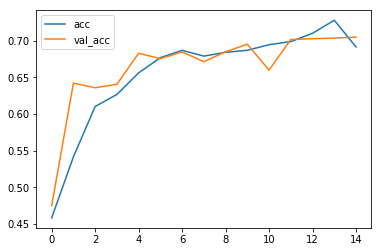

In [82]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()